In [2]:
# Move up a directory (until the root of the git repo),
# but only if this has not been done before.
if 'in_correct_dir' not in locals():
    %cd -q ..
in_correct_dir = True
%pwd

'/home/wout/pp/code'

In [5]:
import io
import json
from pathlib import Path

import ipywidgets as W
from PIL import Image
from IPython.display import display

import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("artifacts/results/mnist_default_k10_e5.csv")
# df = pd.read_csv("artifacts/results/mnist_default_k5_e10.csv")
df = pd.read_csv("artifacts/results/cifar10_default_k5_e10.csv")
# df = pd.read_csv("results.csv")
df.syst_prediction = df.syst_prediction.map(lambda s: np.array(json.loads(s)))
df.asss_prediction = df.asss_prediction.map(lambda s: np.array(json.loads(s)))
display(df.dtypes)
display(df.head(10))
display(df.describe())

inst_index           int64
inst_label           int64
syst_features        int64
syst_prediction     object
syst_pred_loss     float64
syst_pred_score    float64
asss_prediction     object
asss_pred_loss       int64
dtype: object

,inst_index,inst_label,syst_features,syst_prediction,syst_pred_loss,syst_pred_score,asss_prediction,asss_pred_loss
0,58000,1,0,"[[0.10663478076457977, 0.8549673557281494, 0.0...",0.156692,1.0,[0.623041570186615],0
1,46000,0,1,"[[0.8855873942375183, 1.8974586055264808e-05, ...",0.121504,1.0,[0.7409738302230835],0
2,34000,8,2,"[[0.0055359965190291405, 6.150279205030529e-06...",0.005561,1.0,[0.9826626777648926],0
3,22000,1,3,"[[0.006287619471549988, 0.26779115200042725, 0...",1.317548,0.0,[0.21877214312553406],0
4,10000,0,4,"[[0.8661781549453735, 0.0002929475740529597, 0...",0.143665,1.0,[0.7437847256660461],0
5,58001,2,0,"[[0.06719469279050827, 0.0030759070068597794, ...",0.126706,1.0,[0.5170809030532837],0
6,46001,5,1,"[[6.808643956901506e-05, 1.6727026377338916e-0...",0.047306,1.0,[0.7705405354499817],0
7,34001,0,2,"[[0.25203603506088257, 0.015620254911482334, 0...",1.378183,0.0,[0.6706653237342834],1
8,22001,9,3,"[[0.0001992421312024817, 0.07927922904491425, ...",2.535568,0.0,[0.7087281346321106],1
9,10001,1,4,"[[0.0001760555460350588, 0.7234034538269043, 0...",0.323788,1.0,[0.8341013193130493],0


,inst_index,inst_label,syst_features,syst_pred_loss,syst_pred_score,asss_pred_loss
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,34999.500000,4.531300,2.000000,0.870786,0.701300,0.255900
std,16981.229916,2.867166,1.414284,1.190484,0.457711,0.593675
min,10000.000000,0.000000,0.000000,0.000003,0.000000,0.000000
25%,22499.750000,2.000000,1.000000,0.067924,0.000000,0.000000
50%,34999.500000,5.000000,2.000000,0.382281,1.000000,0.000000
75%,47499.250000,7.000000,3.000000,1.231819,1.000000,0.000000
max,59999.000000,9.000000,4.000000,12.472143,1.000000,6.000000


In [23]:
from sklearn.metrics import classification_report
print(f"Num base mispredictions {(df.syst_pred_score == 0).sum() }")
print(classification_report(df.inst_label, df.syst_prediction.map(lambda p: np.argmax(p, axis=1)[0])))

Num base mispredictions 2987
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       937
           1       0.79      0.81      0.80      1021
           2       0.61      0.57      0.59      1011
           3       0.54      0.51      0.52      1016
           4       0.66      0.65      0.66      1005
           5       0.59      0.57      0.58       968
           6       0.76      0.79      0.78       972
           7       0.75      0.76      0.76      1037
           8       0.80      0.82      0.81      1026
           9       0.75      0.80      0.78      1007

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



Num base mispredictions 2987


asss_prediction,False,True
syst_pred_score,,
0.0,621,2366
1.0,768,6245


'Brier Score: 0.3134'

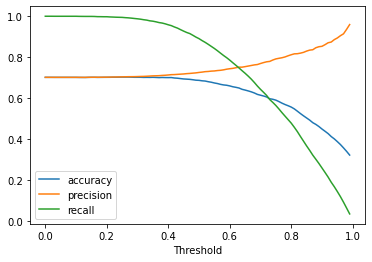

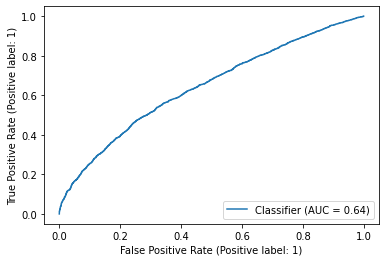

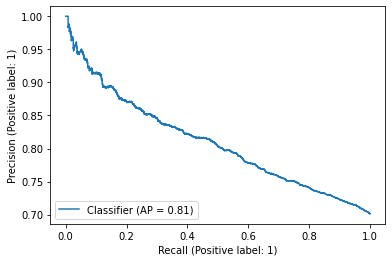

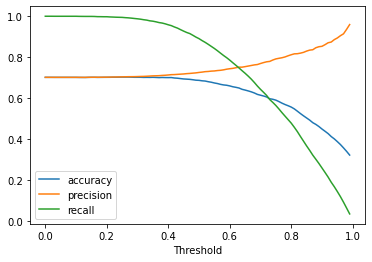

In [13]:
from sklearn.metrics import roc_curve, brier_score_loss, RocCurveDisplay, PrecisionRecallDisplay, accuracy_score, precision_score, recall_score, balanced_accuracy_score, classification_report


def metrics_for_threshold(df, threshold = 0.5):
    preds = df.asss_prediction.map(lambda p: p[0] > threshold)
    display(pd.crosstab(df.syst_pred_score, preds))
    display(f"Brier Score: {brier_score_loss(df.syst_pred_score, preds)}")

metrics_for_threshold(df, 0.5)
# metrics_for_treshold(df, 0.0)
# Make AUC
# Give it identity feature
RocCurveDisplay.from_predictions(y_true=df.syst_pred_score, y_pred=df.asss_prediction.map(lambda p: p[0]))
PrecisionRecallDisplay.from_predictions(y_true=df.syst_pred_score, y_pred=df.asss_prediction.map(lambda p: p[0]))

def plot_thresholding(df):
    def metrics_for_threshold2(df, threshold):
        y_true = df.syst_pred_score
        y_pred = df.asss_prediction.map(lambda p: p[0] > threshold)
        return (accuracy_score(y_true, y_pred), precision_score(y_true, y_pred), recall_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred))
    thresholds = np.arange(0, 1, 0.01)
    accuracies, precisions, recalls, bal_accs = zip(*[metrics_for_threshold2(df, t) for t in thresholds])
    fig = plt.figure()
    ax = plt.gca()
    # ax = fig.axes[0]
    ax.plot(thresholds, accuracies, label="accuracy")
    ax.plot(thresholds, precisions, label="precision")
    ax.plot(thresholds, recalls, label="recall")
    # ax.plot(thresholds, bal_accs, label="balanced accuracy")
    ax.set_xlabel("Threshold")
    ax.legend()
    return fig
    
    
display(plot_thresholding(df))